In [1]:
import sys
!{sys.executable} -m pip install phaseportrait

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.optimize import minimize
import phaseportrait as pp
from scipy import fftpack
from scipy.integrate import odeint

## Problem 1 

### 1) SIR Model and Phase Diagrams

In [3]:
def sir_model(t, z, beta, gamma):
    s, i, r = z
    dsdt = -beta * s * i
    didt = beta * s * i - gamma * i
    drdt = gamma * i
    return [dsdt, didt, drdt]

In [4]:
gamma = 1 
beta_vals = [0.9, 3]

i_vals = np.linspace(0.001, 0.9, 15)

t_span = (0, 50) 
t_eval = np.linspace(0, 50, 1000)

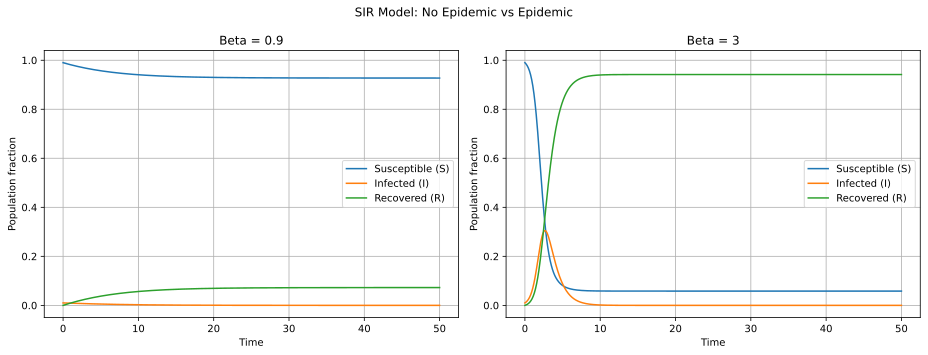

In [5]:
i0 = 0.01
s0 = 1 - i0 
r0 = 0
z0 = [s0, i0, r0]

fig, axes = plt.subplots(1, 2, figsize=(13,5))

for ax, beta in zip(axes, beta_vals):
    sol = solve_ivp(sir_model, t_span, z0, args=(beta, gamma), t_eval=t_eval)
    s, i, r = sol.y
    ax.plot(sol.t, s, label='Susceptible (S)')
    ax.plot(sol.t, i, label='Infected (I)')
    ax.plot(sol.t, r, label='Recovered (R)')
    ax.set_title(f'Beta = {beta}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population fraction')
    ax.grid(True)
    ax.legend()

plt.suptitle('SIR Model: No Epidemic vs Epidemic')
plt.tight_layout()
plt.savefig("sir_model1.png", dpi=300)

In [6]:
i0 = [0, 0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
z0 = []
for i in i0:
    if i == 0.001:
        s0 = np.arange(0.4, 1, 0.1)
        for s in s0:
            r0 = 1 - i - s
            z = [s, i, r0]
            z0.append(z)
    else: 
        r0 = 0 
        s = 1 - i
        z = [s, i, r0]
        z0.append(z)

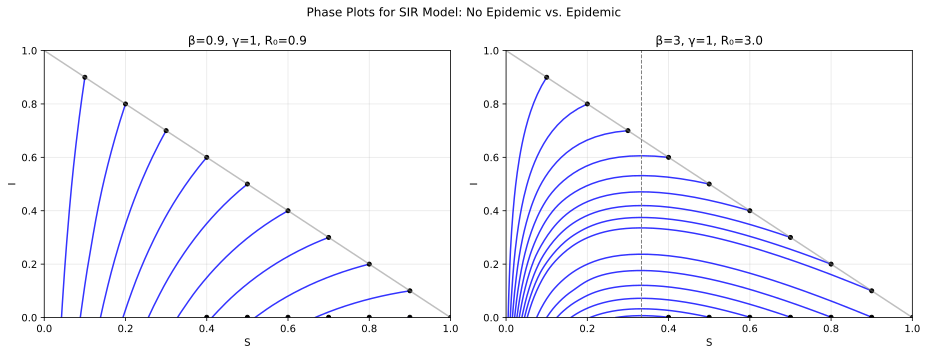

In [7]:
fig, axes = plt.subplots(1, 2, figsize = (13, 5))

for ax, beta in zip(axes, beta_vals):
    for init in z0: 
        s0, i0, r0 = init
        sol = solve_ivp(sir_model, t_span, init, args = (beta, gamma), t_eval=t_eval)
        s, i = sol.y[0], sol.y[1]
        ax.plot(s, i, 'b-', linewidth=1.5, alpha=0.8)
        ax.plot(s0, i0, 'ko', markersize=4)

    ax.axvline(x=gamma/beta, color='gray', linestyle='--', linewidth=1)
    ax.plot([0, 1], [1, 0], 'gray', alpha=0.5)
    ax.set_xlabel('S')
    ax.set_ylabel('I')
    ax.set_title(f'β={beta}, γ={gamma}, R₀={beta/gamma:.1f}')
    ax.grid(alpha=0.3)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

plt.suptitle('Phase Plots for SIR Model: No Epidemic vs. Epidemic')
plt.tight_layout()
plt.savefig("phase_plots.png", dpi=300)

### 2) Model fit 

In [8]:
data = {
    "Day": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],
    "Infected": [1,3,8,28,75,221,291,255,235,190,125,70,28,12,5]
}

df = pd.DataFrame(data)

days = df["Day"].to_numpy()
N = 763
i_data = df["Infected"]/N 

In [9]:
i0 = 1/763 
s0 = 1-i0 
r0 = 0
z0 = [s0, i0, r0]

def loss(params):
    beta, gamma = params 
    sol = solve_ivp(sir_model, (days[0], days[-1]), z0, args = (beta, gamma), t_eval=days)
    i_model = sol.y[1]
    return np.sum((i_model-i_data)**2)

initial_guess = [3, 1]   
bounds = [(0,10), (0,10)]

result = minimize(loss, initial_guess, bounds=bounds)
beta_opt, gamma_opt = result.x

In [10]:
t_fit = np.linspace(days[0], days[-1], 200)

sol_fit = solve_ivp(sir_model, (days[0], days[-1]), z0, args = (beta_opt, gamma_opt), t_eval=t_fit)

Estimated beta: 1.6648, gamma: 0.4480


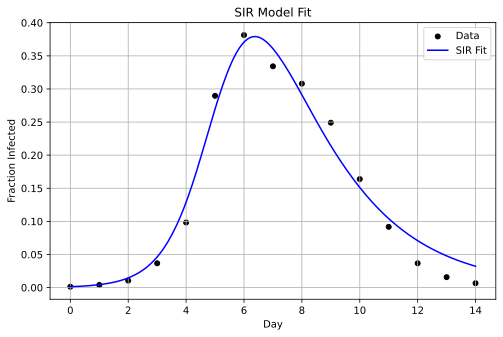

In [11]:
plt.figure(figsize=(8, 5))
plt.scatter(days, i_data, color='black', label='Data', s=25)        
plt.plot(t_fit, sol_fit.y[1], 'b-', label='SIR Fit', linewidth=1.5)         
plt.xlabel('Day')
plt.ylabel('Fraction Infected')
plt.title('SIR Model Fit')
plt.legend()
plt.grid(True)

print(f"Estimated beta: {beta_opt:.4f}, gamma: {gamma_opt:.4f}")
plt.savefig("sir_modelfit.png", dpi=300)

### 3) Vaccination strategies

In [12]:
np.random.seed(10)

N = 763 
i0 = 1/N
s0 = 1 - i0 
r0 = 0 

u = 25
noise = 5
days = np.arange(15)

vacc_daily = np.random.normal(u, noise, size = len(days))
vacc_daily = vacc_daily/N
print(vacc_daily)
print(s0)
print(i0)

[0.04149139 0.03745268 0.02263827 0.03271046 0.03683706 0.02804662
 0.03450532 0.03347673 0.03279352 0.03162123 0.03560305 0.040649
 0.02644125 0.03950376 0.03426363]
0.9986893840104849
0.001310615989515072


In [13]:
def sir_vaccination1(t, z):
    s, i, r = z 
    day = int(t)
    if day >= len(vacc_daily):
        vacc_frac = 0 
    else: 
        vacc_frac = vacc_daily[day]
    
    dsdt = -beta_opt * s * i - vacc_frac
    didt = beta_opt * s * i - gamma_opt * i
    drdt = gamma_opt * i + vacc_frac

    return [dsdt, didt, drdt]

In [14]:
z0 = [s0, i0, r0]

sol_vacc = solve_ivp(sir_vaccination1, (days[0], days[-1]), z0, t_eval = days)

In [15]:
vacc_daily_fast = np.zeros(len(days))
vacc_daily_fast[:3] = 127 / N  

In [16]:
def sir_vacc_fast(t, z):
    s, i, r = z
    day = int(t)
    if day >= len(vacc_daily_fast):
        vacc_frac = 0
    else:
        vacc_frac = vacc_daily_fast[day]
    
    dsdt = -beta_opt * s * i - vacc_frac
    didt = beta_opt * s * i - gamma_opt * i
    drdt = gamma_opt * i + vacc_frac  
    
    return [dsdt, didt, drdt]

In [17]:
sol_fast = solve_ivp(sir_vacc_fast, (days[0], days[-1]), z0, t_eval=days)

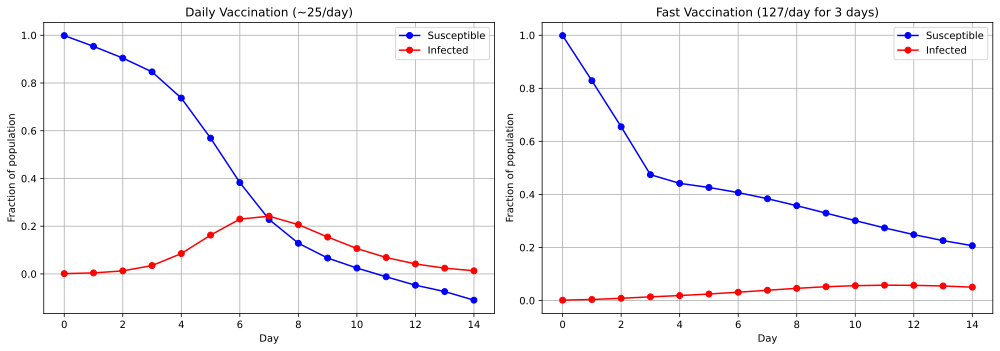

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))  

axes[0].plot(sol_vacc.t, sol_vacc.y[0], 'b-o', label='Susceptible')
axes[0].plot(sol_vacc.t, sol_vacc.y[1], 'r-o', label='Infected')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Fraction of population')
axes[0].set_title('Daily Vaccination (~25/day)')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(sol_fast.t, sol_fast.y[0], 'b-o', label='Susceptible')
axes[1].plot(sol_fast.t, sol_fast.y[1], 'r-o', label='Infected')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Fraction of population')
axes[1].set_title('Fast Vaccination (127/day for 3 days)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("combined_vacc.png", dpi=300)
plt.show()

## Problem 2

In [19]:
def sir_with_demo(t, z, beta, gamma, u):
    s, i, r = z 
    dsdt = u - beta*s*i - u*s
    didt = beta*s*i - i*gamma - u*i
    drdt = gamma*i - u*r 
    return [dsdt, didt, drdt]

In [20]:
beta = 1
gamma = 1/3
u = 1/60 

i0 = 0.01
s0 = 1 - i0 
r0 = 0 
z0 = [s0, i0, r0]

t_span = (0, 300)
t_eval = np.linspace(0, 300, 1000)

sol = solve_ivp(sir_with_demo, t_span, z0, args=(beta, gamma, u), t_eval=t_eval)
s, i, r = sol.y

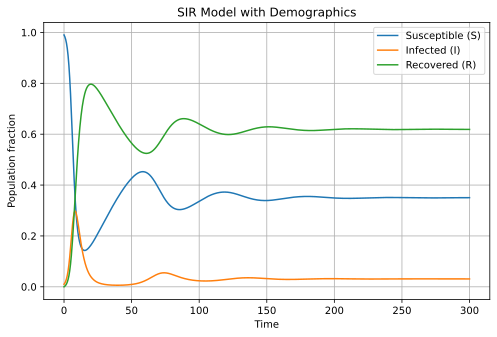

In [21]:
plt.figure(figsize=(8,5))
plt.plot(sol.t, s, label='Susceptible (S)')
plt.plot(sol.t, i, label='Infected (I)')
plt.plot(sol.t, r, label='Recovered (R)')
plt.xlabel('Time')
plt.ylabel('Population fraction')
plt.title('SIR Model with Demographics')
plt.legend()
plt.grid(True)
plt.savefig("sir_model2.png", dpi=300)

In [22]:
i0 = [0, 0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
z0 = []
for i in i0:
    if i == 0.001:
        s0 = np.arange(0.4, 1, 0.1)
        for s in s0:
            r0 = 1 - i - s
            z = [s, i, r0]
            z0.append(z)
    else: 
        r0 = 0 
        s = 1 - i
        z = [s, i, r0]
        z0.append(z)

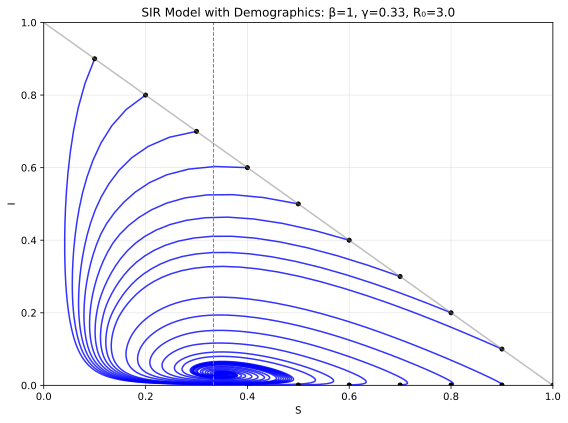

In [23]:
fig, ax = plt.subplots(figsize=(8,6))  

for init in z0:
    s_init, i_init, r_init = init
    sol = solve_ivp(sir_with_demo, t_span, init, args=(beta, gamma, u), t_eval=t_eval)
    s, i = sol.y[0], sol.y[1]
    ax.plot(s, i, 'b-', linewidth=1.5, alpha=0.8)
    ax.plot(s_init, i_init, 'ko', markersize=4)

ax.axvline(x=gamma/beta, color='gray', linestyle='--', linewidth=1)
ax.plot([0, 1], [1, 0], 'gray', alpha=0.5)

ax.set_xlabel('S')
ax.set_ylabel('I')
ax.set_title(f'SIR Model with Demographics: β={beta}, γ={gamma:.2f}, R₀={beta/gamma:.1f}')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("phase_plot2.png", dpi=300)

In [24]:
B = 520
y = 1/7*365
u = 1/70 

s0 = 0.1
i0 = 2.5 * 10**(-4)
r0 = 1 - s0 - i0 
z0 = [s0, i0, r0]

t_eval = np.linspace(0, 60, 1000)
t_span = (0, 60)

sol2 = solve_ivp(sir_with_demo, t_span = t_span, y0=z0, args = (B, y, u), t_eval = t_eval, method='RK45', rtol=1e-6, atol=1e-8)
s2, i2, r2 = sol2.y

In [25]:
dt = t_eval[1] - t_eval[0]  

fourier = fftpack.fft(i2)
freqs = fftpack.fftfreq(len(i2), d=dt)
amplitude = np.abs(fourier)

pos_mask = freqs > 0
freqs_pos = freqs[pos_mask]
amp_pos = amplitude[pos_mask]

peak_idx = np.argmax(amp_pos)
dom_freq = freqs_pos[peak_idx]
dom_amp = amp_pos[peak_idx]
dom_per = 1 / dom_freq  

print(f"Dominant frequency: {dom_freq:.3f} 1/year")
print(f"Amplitude at peak: {dom_amp:.3f}")
print(f"Dominant period: {dom_per:.2f} years")

Dominant frequency: 0.416 1/year
Amplitude at peak: 0.002
Dominant period: 2.40 years


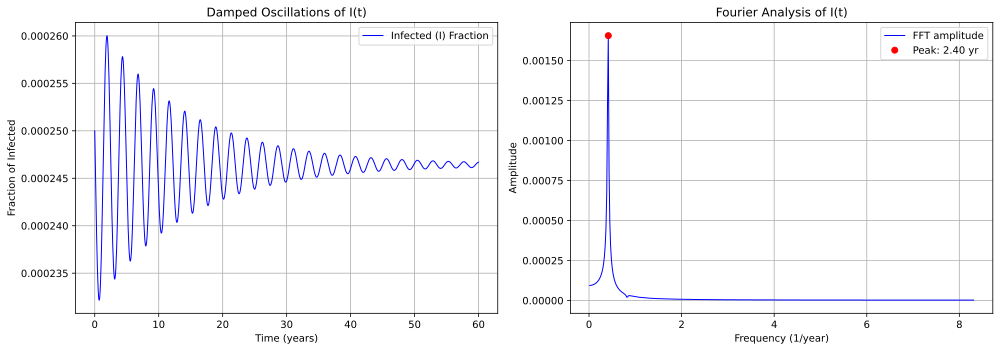

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))  

axes[0].plot(sol2.t, i2, color="blue", linewidth=1, label='Infected (I) Fraction')
axes[0].set_xlabel("Time (years)")
axes[0].set_ylabel("Fraction of Infected")
axes[0].set_title("Damped Oscillations of I(t)")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(freqs_pos, amp_pos, color="blue", linewidth=1, label='FFT amplitude')
axes[1].plot(dom_freq, dom_amp, 'ro', label=f'Peak: {dom_per:.2f} yr')
axes[1].set_xlabel('Frequency (1/year)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Fourier Analysis of I(t)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("damped_fft_combined.png", dpi=300)
plt.show()

In [27]:
def sir_with_mortality(t, P, beta, gamma, u, rho):
    x, y, z = P
    N = x + y + z 
    dxdt = u*N - beta*x*y/N - u*x
    dydt = beta*x*y/N - (gamma+u)/(1-rho)*y
    dzdt = gamma*y - u*z
    return [dxdt, dydt, dzdt]

N0 = 10**6
y0 = 0.01*N0
x0 = N0 - y0 
z0 = 0 
init = [x0, y0, z0]

beta = 1
gamma = 1/3 
u = 1/60
rho = (0.5, 0.6, 0.7)

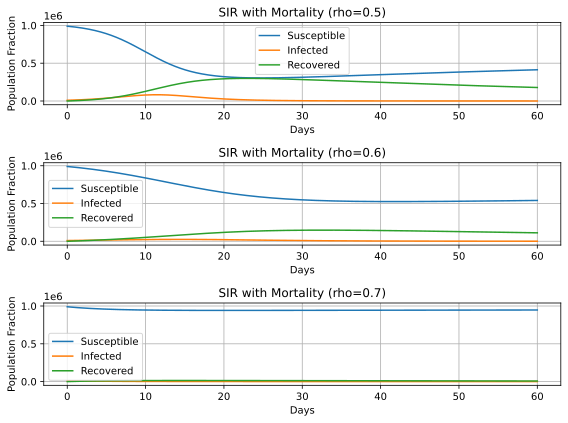

In [28]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6))

for i, r in enumerate(rho):
    sol = solve_ivp(sir_with_mortality, t_span, init, args=(beta, gamma, u, r), t_eval=t_eval)
    x, y, z = sol.y
    
    axs[i].plot(sol.t, x, label='Susceptible')
    axs[i].plot(sol.t, y, label='Infected')
    axs[i].plot(sol.t, z, label='Recovered')
    axs[i].set_xlabel('Days')
    axs[i].set_ylabel('Population Fraction')
    axs[i].set_title(f'SIR with Mortality (rho={r})')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.savefig("inf_mortality.png", dpi=300)

## Problem 3

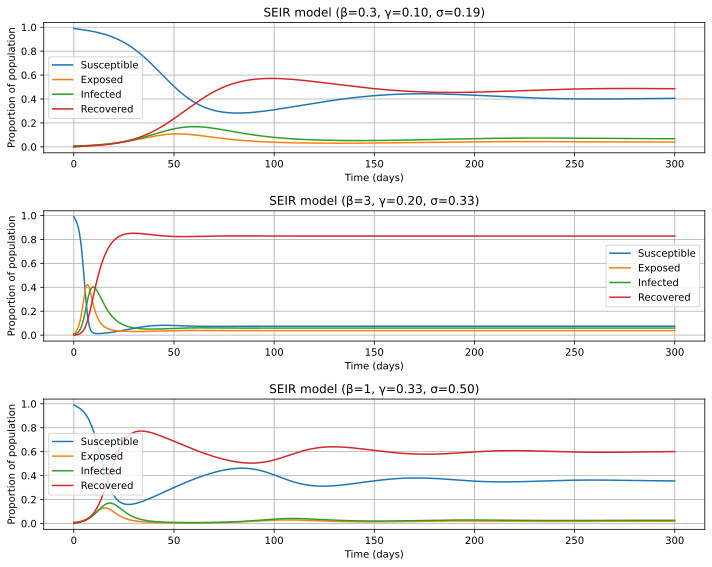

In [29]:
def seir_model(t, z, beta, gamma, sigma, u):
    s, e, i, r = z 
    dsdt = u - (beta*i + u)*s
    dedt = beta*s*i - (u + sigma)*e
    didt = sigma*e - (u + gamma)*i
    drdt = gamma*i - u*r
    return [dsdt, dedt, didt, drdt]

i0 = 0.01
s0 = 1 - i0 
e0 = 0 
r0 = 0 
z0 = [s0, e0, i0, r0]

beta = [0.3, 3, 1]
gamma = [1/10, 1/5, 1/3]
sigma = [1/5.2, 1/3, 1/2]
u = 1/70

t_span = (0,300)
t_eval = np.linspace(0, 300, 2000)

fig, axs = plt.subplots(3, 1, figsize=(10, 8))

for idx in range(len(beta)):
    sol = solve_ivp(seir_model, t_span, z0, args=(beta[idx], gamma[idx], sigma[idx], u), t_eval=t_eval)
    s, e, i, r = sol.y
    
    axs[idx].plot(sol.t, s, label='Susceptible')
    axs[idx].plot(sol.t, e, label='Exposed')
    axs[idx].plot(sol.t, i, label='Infected')
    axs[idx].plot(sol.t, r, label='Recovered')
    axs[idx].set_title(f'SEIR model (β={beta[idx]}, γ={gamma[idx]:.2f}, σ={sigma[idx]:.2f})')
    axs[idx].set_xlabel('Time (days)')
    axs[idx].set_ylabel('Proportion of population')
    axs[idx].legend()
    axs[idx].grid(True)

plt.tight_layout()
plt.savefig('seir.png', dpi=300)

In [30]:
R0 = 10 
T = 2.8
B1 = 0.225
u = 0.02 
sigma = 365/8
gamma = 365/5

B0 = R0 * (sigma + u) * (gamma + u) / sigma

w = 2*np.pi/T

i0 = 10**(-3)
e0 = 10**(-3)
s0 = 6*10**(-2)
r0 = 0 
z0_forcing = [s0, e0, i0, r0]

t_span = (0, 60)
t_eval = np.linspace(0, 60, 3000)  

def B_fun(t):
    return B0*(1 + B1*np.cos(w*t))

def seir_with_forcing(t, z, gamma, sigma, u):
    s, e, i, r = z
    B_t = B_fun(t)
    dsdt = u - (B_t*i + u)*s
    dedt = B_t*s*i - (u + sigma)*e
    didt = sigma*e - (u + gamma)*i
    drdt = gamma*i - u*r
    return [dsdt, dedt, didt, drdt]

sol = solve_ivp(seir_with_forcing, t_span, z0_forcing, args=(gamma, sigma, u), 
                t_eval=t_eval, method='DOP853', rtol=1e-10, atol=1e-12)

s, e, i, r = sol.y

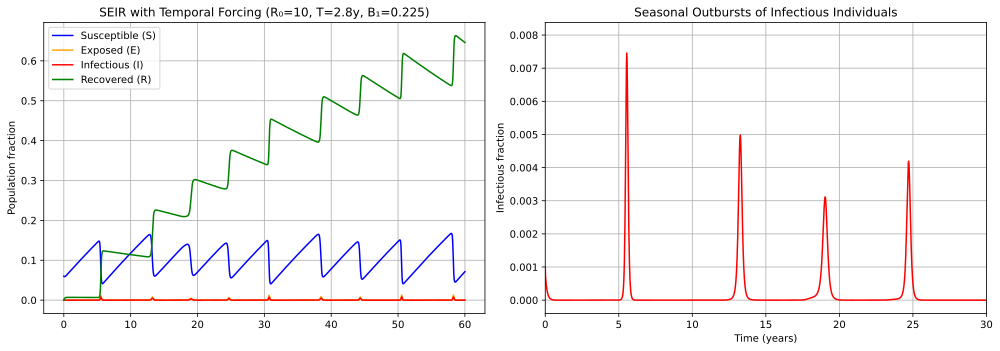

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(sol.t, s, 'b-', label="Susceptible (S)")
axs[0].plot(sol.t, e, color='orange', label="Exposed (E)")
axs[0].plot(sol.t, i, 'r-', label="Infectious (I)")
axs[0].plot(sol.t, r, 'g-', label="Recovered (R)")
axs[0].set_ylabel("Population fraction")
axs[0].set_title(f"SEIR with Temporal Forcing (R₀={R0}, T={T}y, B₁={B1})")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(sol.t, i, 'r-')
axs[1].set_xlabel("Time (years)")
axs[1].set_ylabel("Infectious fraction")
axs[1].set_title("Seasonal Outbursts of Infectious Individuals")
axs[1].grid(True)
axs[1].set_xlim(0, 30)

plt.tight_layout()
plt.savefig("seir_temporal_forcing.png", dpi=300)  
plt.show()